# Approximation of a time-dependent 3D bubble shape

## Outline

1. [Starting point](#starting_point)
2. [Parameterization](#parameterization)
3. [Training, validation, and test data](#data_splitting)
4. [Simple function approximation](#function_approximation)
5. [Model training](#model_training)
6. [Testing the model](#model_test)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>

- approximate r(phi, theta, t)
- moving reference frame data, include animation

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
from helper_module import SimpleMLP, approximate_function
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import urllib
    import cloudpickle as cp
else:
    import pickle
    matplotlib.rcParams['figure.dpi'] = 80
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Sklearn version: {}".format(sk.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))
print("Executing PyTorch operations using {}.".format(device))

Pandas version: 0.24.2
Numpy version: 1.14.2
PyTorch version: 0.4.1
Sklearn version: 0.19.1
Running notebook locally.
Executing PyTorch operations using cpu.


In [2]:
if not IN_COLAB:
    data_file = "../data/3mm_l12_shape.pkl"
    with open(data_file, 'rb') as file:
        data = pickle.load(file)
else:
    data_file = "https://github.com/AndreWeiner/machine-learning-applied-to-cfd/blob/master/data/3mm_l12_shape.pkl?raw=true"
    response = urllib.request.urlopen(data_file)
    data = cp.load(response)

print("The data set contains {} points.".format(data.shape[0]))
data.sample(10)

The data set contains 1168729 points.


,x,y,z,t
988847,0.525953,-0.154058,-0.110452,4.295154
293002,-0.198707,-0.186972,0.468748,1.343612
931400,-0.077467,-0.249959,0.305838,4.074890
1084079,0.478185,-0.170883,-0.187902,4.691630
178014,-0.292885,0.031591,-0.458923,0.815347
865983,0.398345,0.211146,-0.069446,3.788546
819281,0.050134,-0.250906,0.314333,3.568282
776634,-0.627065,-0.065389,-0.124151,3.480176
169948,0.293055,-0.351665,0.087951,0.727417
248360,-0.175746,-0.296902,0.322294,1.123348


## Parameterization<a id="parameterization"></a>

In [3]:
def spherical_coordinates(px, py, pz):
    '''Converts Cartesian coordinates x, y, z to spherical coordinates r, phi, theta.
    
    Parameters
    ----------
    px, py, pz - array-like: x, y, and z coordinates
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like   : polar angle
    theta - array-like : azimuth angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py) + np.square(pz))
    phi = np.where(px >= 0, np.arccos(py / radius), 2.0 * np.pi - np.arccos(py / radius))
    theta = (np.arctan2(px, pz) + np.pi) % np.pi
    return radius, phi, theta


def cartesian_coordinates(radius, phi, theta):
    '''Converts spherical coordinates r, phi, theta to Cartesian coordinates x, y, z.
    
    Parameters
    ----------
    radius, phi, theta - array-like: radius, polar angle, and azimuth angle
    
    Returns
    -------
    x, y, z - array-like : Cartesian coordinates
    
    '''
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.cos(phi)
    z = radius * np.sin(phi) * np.sin(theta)
    return x, y, z

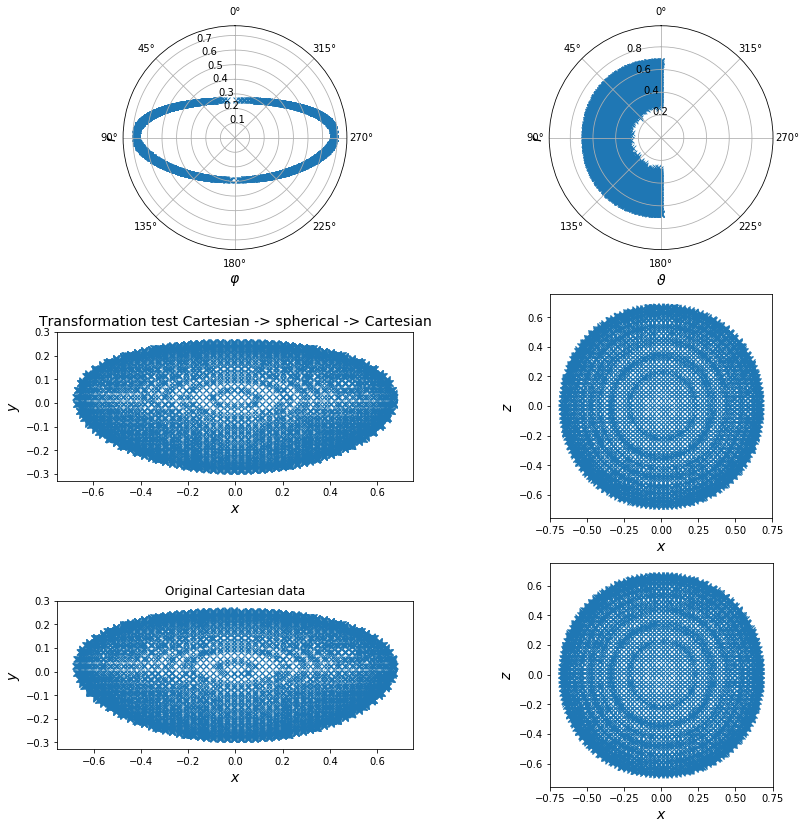

In [4]:
test_time = data.sample(1).t.values[0]
test_data = data[data.t == test_time]

%matplotlib inline
fontsize = 14

fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot(321, projection='polar')
ax2 = plt.subplot(322, projection='polar')
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)

rad, phi, theta = spherical_coordinates(test_data.x.values, test_data.y.values, test_data.z.values)
x, y, z = cartesian_coordinates(rad, phi, theta)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, rad, marker='x', color='C0', s=30, linewidth=0.5)
ax1.set_xlim(0.0, 2.0*np.pi)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.set_theta_zero_location("N")
ax2.scatter(theta, rad, marker='x', color='C0', s=30, linewidth=0.5)
ax1.set_xlim(0.0, 2.0*np.pi)
ax2.set_xlabel(r"$\vartheta$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)

ax3.scatter(x, y, marker='x', color='C0', s=30, linewidth=0.5)
ax3.set_xlabel(r"$x$", fontsize=fontsize)
ax3.set_ylabel(r"$y$", fontsize=fontsize)
ax3.set_aspect('equal')
ax3.set_title(r"Transformation test Cartesian -> spherical -> Cartesian", fontsize=fontsize)

ax4.scatter(x, z, marker='x', color='C0', s=30, linewidth=0.5)
ax4.set_xlabel(r"$x$", fontsize=fontsize)
ax4.set_ylabel(r"$z$", fontsize=fontsize)
ax4.set_aspect('equal')

ax5.scatter(test_data.x.values, test_data.y.values, marker='x', color='C0', s=30, linewidth=0.5)
ax5.set_xlabel(r"$x$", fontsize=fontsize)
ax5.set_ylabel(r"$y$", fontsize=fontsize)
ax5.set_aspect('equal')
ax5.set_title(r"Original Cartesian data")

ax6.scatter(test_data.x.values, test_data.z.values, marker='x', color='C0', s=30, linewidth=0.5)
ax6.set_xlabel(r"$x$", fontsize=fontsize)
ax6.set_ylabel(r"$z$", fontsize=fontsize)
ax6.set_aspect('equal')
    
plt.show()

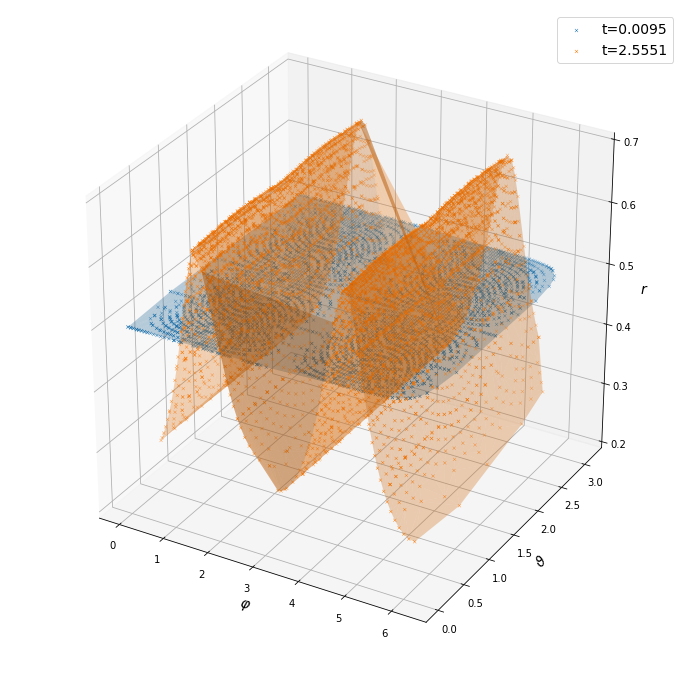

In [5]:
every_instance = 25
times = sorted(data['t'].unique())[::every_instance]

every = 4
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colors = ["C{:1d}".format(i) for i in range(len(times))]

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    rad_t, phi_t, theta_t = spherical_coordinates(data_temp.x.values, data_temp.y.values, data_temp.z.values)
    ax.scatter(phi_t[::every], theta_t[::every], rad_t[::every],
               marker='x', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
    ax.plot_trisurf(phi_t[::every], theta_t[::every], rad_t[::every], color=colors[i], alpha=0.3)

ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
ax.set_zlabel(r"$r$", fontsize=fontsize)
ax.set_zlim(0.2, 0.7)
plt.legend(fontsize=fontsize)
plt.show()

## Using an ellipsoidal base shape to simplify the learning problem<a id="ellipsoidal_base_shape"></a>

In [6]:
def estimate_half_axis(x, y, z):
    ''' Estimate the half axis of an ellipsoid from a point cloud.
    
    Parameters
    ----------
    x, y, z - array-like : Cartesian coordinates
    
    Returns
    -------
    a, b, c - Float : half axis of the ellipsoid
    
    '''
    a = 0.5 * (np.amax(x) - np.amin(x))
    b = 0.5 * (np.amax(y) - np.amin(y))
    c = 0.5 * (np.amax(z) - np.amin(z))
    return a, b, c
    
    
def ellipsoidal_radius(phi, theta, t, axis_model):
    '''Compute the radius of an ellipsoid with instantaneous half axis.
    
    Parameters
    ----------
    phi, theta - array-like : polar and azimuth angle
    t - array-like          : time
    axis_model - SimpleMLP  : PyTorch model to compute instantaneous half axis
    
    Returns
    -------
    radius - array-like : instantaneous ellipsoidal radius
    
    '''
    t_tensor = torch.from_numpy(t.astype(np.float32))
    a, b, c = axis_model(t_tensor).detach().numpy().T
    radius = np.sqrt(np.square(a * np.sin(phi) * np.cos(theta))
                   + np.square(b * np.cos(phi))
                   + np.square(c * np.sin(phi) * np.sin(theta)))
    return radius

In [7]:
half_axis = []
for time in data["t"].unique():
    data_t = data[data.t == time]
    xt, yt, zt = data_t.x.values, data_t.y.values, data_t.z.values
    half_axis.append(estimate_half_axis(xt, yt, zt))
half_axis = np.asarray(half_axis)

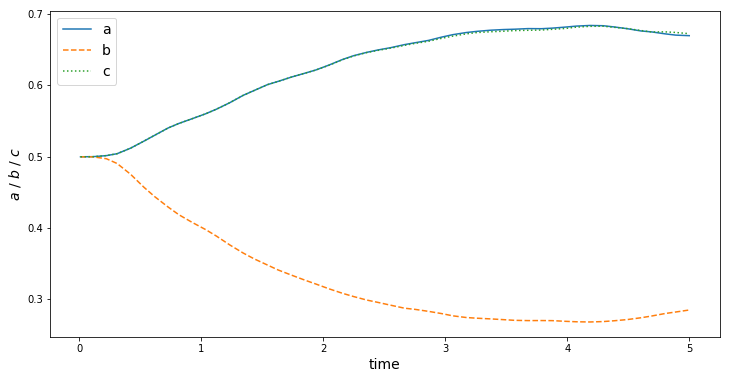

In [8]:
# plot half axis over time
plt.figure(figsize=(12, 6))
plt.plot(data.t.unique(), half_axis[:,0], c="C0", linestyle='-', label="a")
plt.plot(data.t.unique(), half_axis[:,1], c="C1", linestyle='--', label="b")
plt.plot(data.t.unique(), half_axis[:,2], c="C2", linestyle=':', label="c")
plt.xlabel(r"time", fontsize=fontsize)
plt.ylabel(r"$a$ / $b$ / $c$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [9]:
def set_path(name=None):
    if IN_COLAB:
        return F"/content/gdrive/My Drive/" + name
    else:
        return "models/" + name

In [10]:
axis_model = SimpleMLP(n_inputs=1, n_outputs=3, n_layers=2, n_neurons=10, activation=torch.sigmoid, batch_norm=False)
X_train, X_val, axis_train, axis_val = train_test_split(data.t.unique().reshape(-1, 1), half_axis, test_size=0.1, random_state=42)
axis_model, train_loss, val_loss = approximate_function(X_train, axis_train, X_val, axis_val, axis_model, max_iter=10000,
                                            l_rate=0.01, batch_size=100, path=set_path("3mm_axis_model.pt"), device='cpu', verbose=1000)

Created model with 163 weights.
Training loss decreased in epoch 1031: 1.4893159459461458e-05
Validation loss/max. dev.: 6.4403257056255825e-06/0.004391491413116455
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 2117: 1.0780615411931649e-05
Validation loss/max. dev.: 3.715637831191998e-06/0.003200918436050415
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 3564: 7.351884505624184e-06
Validation loss/max. dev.: 1.4891455748511362e-06/0.0020612478256225586
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 5245: 4.851022367802216e-06
Validation loss/max. dev.: 3.750990629214357e-07/0.00130540132522583
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 8782: 4.43875478595146e-06
Validation loss/max. dev.: 4.008146277101332e-07/0.0016126036643981934
-------------

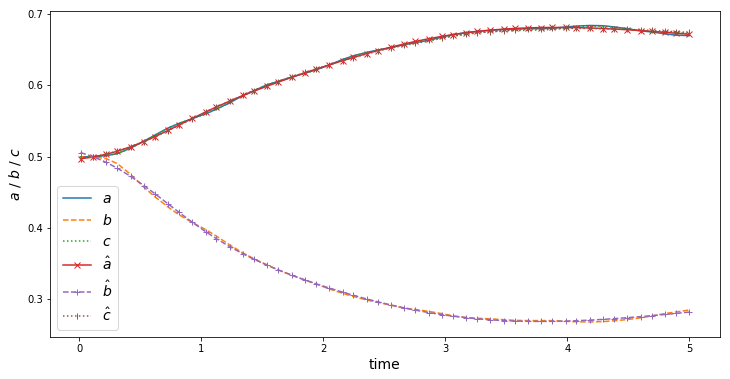

In [11]:
axis_model.load_state_dict(torch.load(set_path("3mm_axis_model.pt")))
a_model, b_model, c_model = axis_model(torch.from_numpy(data.t.unique().reshape(-1, 1).astype(np.float32))).detach().numpy().T

# plot deviation over time
plt.figure(figsize=(12, 6))
plt.plot(data.t.unique(), half_axis[:,0], c="C0", linestyle='-', label=r"$a$")
plt.plot(data.t.unique(), half_axis[:,1], c="C1", linestyle='--', label=r"$b$")
plt.plot(data.t.unique(), half_axis[:,2], c="C2", linestyle=':', label=r"$c$")
plt.plot(data.t.unique(), a_model, c="C3", linestyle='-', marker='x', label="$\hat{a}$")
plt.plot(data.t.unique(), b_model, c="C4", linestyle='--', marker='+', label="$\hat{b}$")
plt.plot(data.t.unique(), c_model, c="C5", linestyle=':', marker='|', label="$\hat{c}$")
plt.xlabel(r"time", fontsize=fontsize)
plt.ylabel(r"$a$ / $b$ / $c$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [12]:
rad, phi, theta = spherical_coordinates(data.x.values, data.y.values, data.z.values)
radius_ellipsoid = ellipsoidal_radius(phi, theta, data.t.values.reshape(-1, 1), axis_model)
radius_scaled = rad / radius_ellipsoid
radius_scaled_01 = (radius_scaled - np.amin(radius_scaled)) / (np.amax(radius_scaled) - np.amin(radius_scaled))

print("Mean/stdev of original radius: {:2.4f}/{:2.4f}".format(np.mean(rad), np.std(rad)))
print("Mean/stdev of rescaled radius: {:2.4f}/{:2.4f}".format(np.mean(radius_scaled), np.std(radius_scaled)))
print("Mean/stdev of rescaled radius [0,1]: {:2.4f}/{:2.4f}".format(np.mean(radius_scaled_01), np.std(radius_scaled_01)))

Mean/stdev of original radius: 0.5306/0.0938
Mean/stdev of rescaled radius: 0.9090/0.0965
Mean/stdev of rescaled radius [0,1]: 0.5885/0.1881


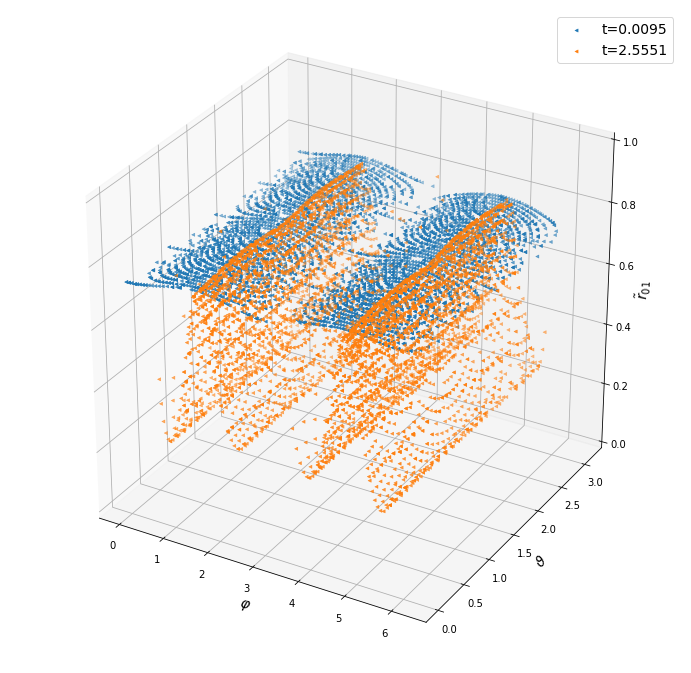

In [13]:
every_instance = 25
times = sorted(data['t'].unique())[::every_instance]

every = 4
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colors = ["C{:1d}".format(i) for i in range(len(times))]

data["rad_01"] = radius_scaled_01

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    rad_t, phi_t, theta_t = spherical_coordinates(data_temp.x.values, data_temp.y.values, data_temp.z.values)
    ax.scatter(phi_t[::every], theta_t[::every], data_temp.rad_01.values[::every],
               marker='<', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
ax.set_zlabel(r"$\tilde{r}_{01}$", fontsize=fontsize)
ax.set_zlim(0.0, 1.0)
plt.legend(fontsize=fontsize)
plt.show()

## Training, validation, and test data<a id="data_splitting"></a>

In [14]:
X = np.vstack([phi, theta, data.t.values]).T
X_train, X_tv, r_train, r_tv = train_test_split(X, data.rad_01.values, test_size=0.2, random_state=42)
X_val, X_test, r_val, r_test = train_test_split(X_tv, r_tv, test_size=0.5, random_state=42)

print("The training set contains {} points.".format(X_train.shape[0]))
print("The validation set contains {} points.".format(X_val.shape[0]))
print("The test set contains {} points.".format(X_test.shape[0]))

The training set contains 934983 points.
The validation set contains 116873 points.
The test set contains 116873 points.


## Simple function approximation<a id="function_approximation"></a>

In [15]:
radius_model = SimpleMLP(n_inputs=3, n_outputs=1, n_layers=8, n_neurons=40, activation=torch.relu, batch_norm=False)
radius_model, train_loss, val_loss = approximate_function(X_train, r_train, X_val, r_val, radius_model, max_iter=1000,
                                            l_rate=0.001, batch_size=50000, path=set_path("3mm_radius_model.pt"), device=device, verbose=1)

Created model with 11681 weights.
Training loss decreased in epoch 1: 0.24274063502487384
Validation loss/max. dev.: 0.16782650351524353/0.7539963722229004
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 2: 0.0881608252070452
Validation loss/max. dev.: 0.04569992795586586/0.6902133226394653
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 3: 0.04354081087206539
Validation loss/max. dev.: 0.039042748510837555/0.6688260436058044
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 4: 0.03483459235806214
Validation loss/max. dev.: 0.03125709295272827/0.5733548402786255
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 5: 0.029651368036866188
Validation loss/max. dev.: 0.02846204675734043/0.5178620219230652
--------------------------------
Saving model as mo

Training loss decreased in epoch 42: 0.0019116416009829233
Validation loss/max. dev.: 0.0017908269073814154/0.7885096669197083
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 43: 0.0018025245578763517
Validation loss/max. dev.: 0.0017473583575338125/0.7607672214508057
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 44: 0.0017052094243760955
Validation loss/max. dev.: 0.0016511559952050447/0.7545257806777954
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 45: 0.0016093856814366422
Validation loss/max. dev.: 0.0014085464645177126/0.739134669303894
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 46: 0.0015362000129626769
Validation loss/max. dev.: 0.0013423507334664464/0.7212292551994324
--------------------------------
Saving model as models/3mm_ra

Training loss decreased in epoch 136: 0.00017920474439099627
Validation loss/max. dev.: 0.00019203643023502082/0.18983173370361328
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 158: 0.00016699898007668947
Validation loss/max. dev.: 0.00016412853437941521/0.14426136016845703
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 167: 0.00015615673558051256
Validation loss/max. dev.: 0.00015362550038844347/0.1440325379371643
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 190: 0.00014349060457837033
Validation loss/max. dev.: 0.00017818323976825923/0.11499136686325073
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 211: 0.00013579211449005495
Validation loss/max. dev.: 0.00013711393694393337/0.11134111881256104
--------------------------------
Saving mo

Training loss decreased in epoch 987: 4.245130261743294e-05
Validation loss/max. dev.: 4.181045733275823e-05/0.06761008501052856
--------------------------------
Saving model as models/3mm_radius_model.pt


L_2/L_max on test data set: 0.0000/0.0571


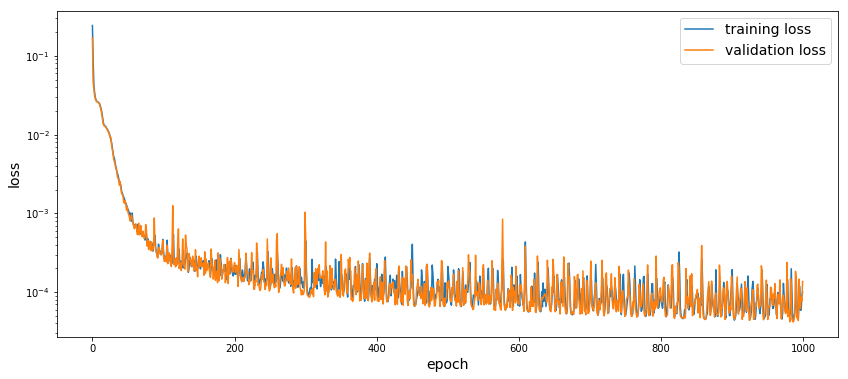

In [16]:
radius_model.to('cpu')
radius_model.load_state_dict(torch.load(set_path("3mm_radius_model.pt")))
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
r01_test_model = np.squeeze(radius_model(X_test_tensor).detach().numpy())
err_test = np.absolute(r_test - r01_test_model)
print("L_2/L_max on test data set: {:2.4f}/{:2.4f}".format(np.mean(np.square(err_test)), np.amax(err_test)))

plt.figure(figsize=(14,6))
plt.semilogy(range(len(train_loss)), train_loss, label=r"training loss")
plt.semilogy(range(len(val_loss)),  val_loss, label=r"validation loss")
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [17]:
X_tensor = torch.from_numpy(X.astype(np.float32))
r01_model = np.squeeze(radius_model(X_tensor).detach().numpy())
rad_model = (r01_model * (np.amax(radius_scaled) - np.amin(radius_scaled)) + np.amin(radius_scaled)) * radius_ellipsoid
err_full = np.absolute(rad - rad_model) / rad
print("Maximum/mean relative error: {:2.2f}/{:2.2f} %".format(np.amax(err_full)*100, np.mean(err_full)*100))

Maximum/mean relative error: 3.81/0.27 %


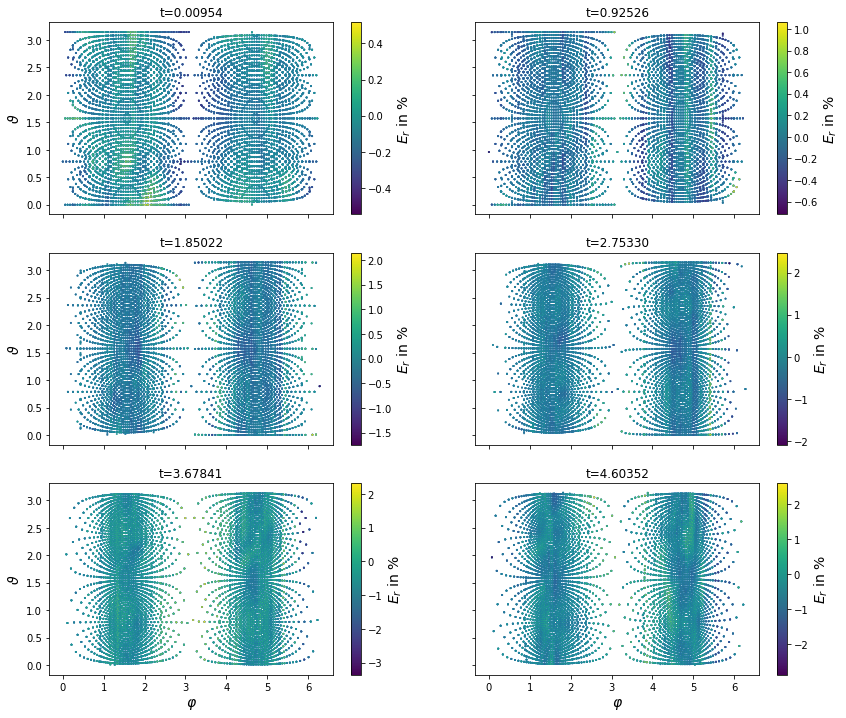

In [18]:
every_instance = 9
times = sorted(data['t'].unique())[::every_instance]

ncols = 2
nrows = int(np.ceil(len(times) / float(ncols)))
ind = [(i, j) for i in range(nrows) for j in range(ncols)]

fig, axarr = plt.subplots(nrows, ncols, figsize=(14, 4*nrows), sharex=True, sharey=True)

data['phi'] = phi
data['theta'] = theta
data['rad'] = rad
data['rad_m'] = rad_model

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    diff = (data_temp.rad.values - data_temp.rad_m.values) / data_temp.rad.values * 100
    ax = axarr[ind[i][0], ind[i][1]]
    sc = ax.scatter(data_temp.phi, data_temp.theta, linewidth=0.2, c=diff,
                    marker='o', facecolors='none', edgecolors='C0', s=3)
    ax.set_title("t={:1.5f}".format(t))
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label(r"$E_r$ in %", fontsize=fontsize)
    
    
for ax in axarr[:, 0]: ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
for ax in axarr[-1, :]: ax.set_xlabel(r"$\varphi$", fontsize=fontsize)

plt.show()

## Building and saving the full model<a id="full_model"></a>

In [19]:
class ShapeModel(torch.nn.Module):
    def __init__(self, axis_model, radius_model, rs_min, rs_max,):
        super().__init__()
        self.axis_model = axis_model
        self.radius_model = radius_model
        self.rs_min = torch.tensor(rs_min)
        self.rs_max = torch.tensor(rs_max)
        
    def forward(self, x):
        # scaled model radius
        rs = self.radius_model(x).squeeze(1)
        # ellipsoidal radius
        re = self.ellipsoidal_radius(x)
        # transform back
        r = (rs * (self.rs_max - self.rs_min) + self.rs_min) * re
        return r
    
    def ellipsoidal_radius(self, x):
        axis = self.axis_model(x[:,2].unsqueeze(-1))
        re = torch.sqrt(
             (axis[:,0] * torch.sin(x[:,0]) * torch.cos(x[:,1]))**2
           + (axis[:,1] * torch.cos(x[:,0]))**2
           + (axis[:,2] * torch.sin(x[:,0]) * torch.sin(x[:,1]))**2
        )
        return re

In [24]:
shape_model = ShapeModel(axis_model, radius_model, np.amin(radius_scaled), np.amax(radius_scaled))
t_0 = data.t.unique()[0]
data_0 = data[data.t == t_0]
X_0 = np.vstack([data_0.phi.values, data_0.theta.values, data_0.t.values]).T
X_0_tensor = torch.from_numpy(X_0.astype(np.float32))
rad_0 = shape_model(X_0_tensor).detach().numpy()
diff = rad_0 - data_0.rad_m.values
print("Maximum deviation: ", np.amax(diff))

Maximum deviation:  1.1920929e-07


In [25]:
traced_shape_model = torch.jit.trace(shape_model, X_0_tensor[0].unsqueeze(0))
traced_shape_model.save(set_path("shape_model.pt"))

## Final notes<a id="final_notes"></a>